In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [7]:
CUDA = 'cuda'
device = CUDA if torch.cuda.is_available() else 'cpu'

In [8]:
data_path = 'data/exchange_rate.txt'

with open(data_path, 'r') as file:
    lines = file.readlines()

# Split each line into individual exchange rates
data = [line.strip().split(',') for line in lines]

# Create a DataFrame
df = pd.DataFrame(data)

# Assign column names
column_names = ['Australia', 'British', 'Canada', 'Switzerland', 'China', 'Japan', 'New Zealand', 'Singapore']
df.columns = column_names

# Optionally, convert exchange rates to numeric values
df = df.astype(float)

# Print the first few rows of the DataFrame
print(df.head())

   Australia  British    Canada  Switzerland     China     Japan  New Zealand  \
0     0.7855   1.6110  0.861698     0.634196  0.211242  0.006838       0.5930   
1     0.7818   1.6100  0.861104     0.633513  0.211242  0.006863       0.5940   
2     0.7867   1.6293  0.861030     0.648508  0.211242  0.006975       0.5973   
3     0.7860   1.6370  0.862069     0.650618  0.211242  0.006953       0.5970   
4     0.7849   1.6530  0.861995     0.656254  0.211242  0.006940       0.5985   

   Singapore  
0   0.525486  
1   0.523972  
2   0.526316  
3   0.523834  
4   0.527426  


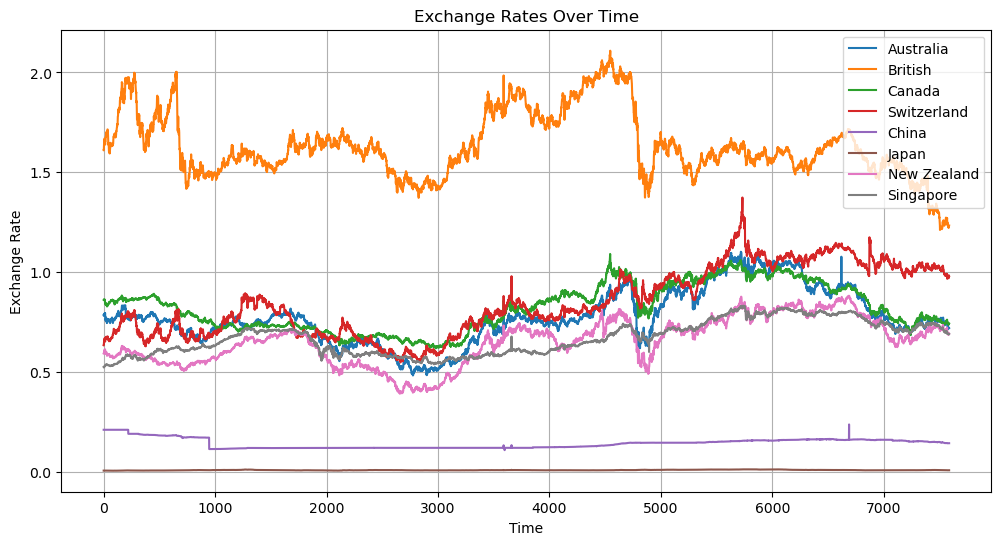

In [9]:
# Plotting the exchange rates over time
plt.figure(figsize=(12, 6))

# Plot each currency exchange rate
for currency in df.columns:
    plt.plot(df.index, df[currency], label=currency)

plt.title('Exchange Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

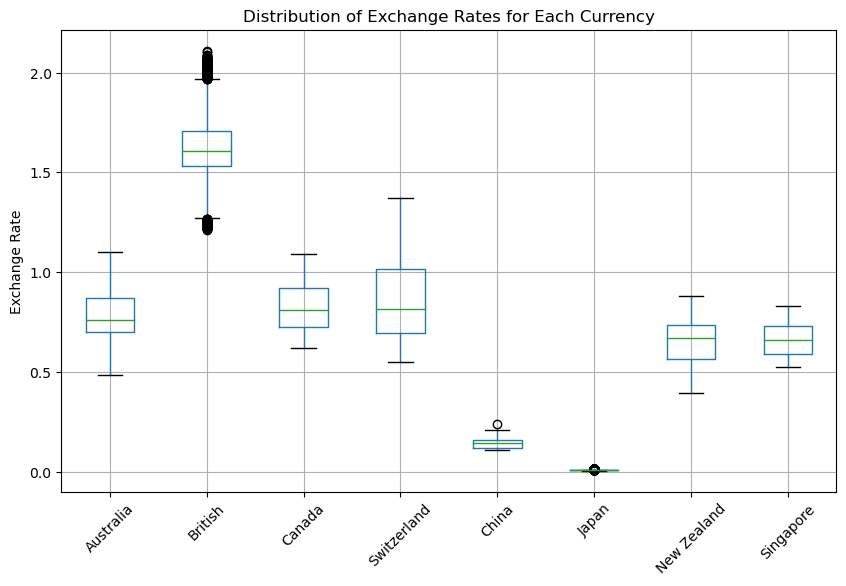

In [10]:
# Box plot of exchange rates for each currency
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Distribution of Exchange Rates for Each Currency')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Get the size of the dataset
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7588
Number of columns: 8


In [12]:
# Define custom dataset class
class ExchangeRateDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - (self.input_len + self.output_len) + 1

    def __getitem__(self, idx):
        idx_end = idx + self.input_len
        input_seq = self.data[idx:idx_end]
        output_seq = self.data[idx_end:idx_end+self.output_len]
        return input_seq, output_seq

In [13]:
# Create DataLoader for train and test sets
input_dim = 10  # Lookback time series length
output_dim = 1  # Predicted length
batch_size = 64
data = df.values
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

train_dataset = ExchangeRateDataset(train_data, input_dim, output_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ExchangeRateDataset(test_data, input_dim, output_dim)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [151]:
#specify the variables you need
n_embd = 8
n_head = 4
n_layer = 8
n_epoch = 10

In [153]:
class SelfAttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        
        self.head_size = head_size
        self.key = nn.Linear(n_embd, head_size, bias=False, dtype=torch.double)
        self.query = nn.Linear(n_embd, head_size, bias=False, dtype=torch.double)
        self.value = nn.Linear(n_embd, head_size, bias=False, dtype=torch.double)

    def forward(self, x):
        K = self.key(x)
        Q = self.query(x)
        V = self.value(x)
        alignment = torch.bmm(Q, K.permute(0, 2, 1)) / np.sqrt(self.head_size)
        attention = torch.softmax(alignment, dim=-1)
        out = torch.bmm(attention, V)
        
        return out


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(n_embd, head_size) for i in range(num_heads)])
        self.projection = nn.Linear(head_size*num_heads, n_embd, dtype=torch.double)
        
    def forward(self, x):
        out = torch.concatenate([head(x) for head in self.heads], dim=-1)
        out = self.projection(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embd, 4 * n_embd, dtype=torch.double), 
                                 nn.ReLU(),
                                 nn.Linear(4 * n_embd, n_embd, dtype=torch.double)) 
        
    def forward(self, x):
        output = self.net(x)
        return output

In [154]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, num_heads):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(num_heads, n_embd, n_embd // num_heads)
        self.feed_forward = FeedForward(n_embd)
        self.norm1 = nn.LayerNorm(n_embd, dtype=torch.double)
        self.norm2 = nn.LayerNorm(n_embd, dtype=torch.double)
        
    def forward(self, x):
        x1 = self.self_attention(x)
        x2 = self.norm1(x1 + x)
        x3 = self.feed_forward(x2)
        x4 = self.norm2(x3 + x2)
        return x4

In [173]:
# Define custom Transformer model
class TransformerModel(nn.Module):
    def __init__(self, n_vars, n_embd, block_size, n_head, n_layer):
        super(TransformerModel, self).__init__()
        self.embeddings = nn.Linear(n_vars, n_embd, dtype=torch.double)
        self.position_embeddings = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[TransformerBlock(n_embd, n_head) for i in range(n_layer)]) 
        self.layer_norm = nn.LayerNorm(n_embd, dtype=torch.double)
        self.lm_head = nn.Linear(n_embd, n_vars, dtype=torch.double)
        
        
    def forward(self, x):
        x = self.embeddings(x) + self.position_embeddings(torch.arange(x.shape[1]))
        x = self.blocks(x)
        x = self.layer_norm(x)
        x = self.lm_head(x)

        return x

lr = 0.005
model = TransformerModel(n_vars=num_columns, n_embd=n_embd, block_size=input_dim, n_head=n_head, n_layer=n_layer).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train(model):
    model.train()
    for epoch in range(n_epoch):
        total_loss = 0
        total = 0
        for batch, label in train_loader:
            batch, label = batch.to(device), label.to(device)
            output = model(batch)[:, -2:-1, :]
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss * len(batch)

        print(f"Epoch({epoch+1}/{n_epoch}): loss: {total_loss / len(train_dataset): .6f}")
        
def test(model):
    squared_error, absolute_error = 0, 0
    for batch, label in test_loader:
        batch, label = batch.to(device), label.to(device)
        output = model(batch)[:, -1, :].detach().numpy()
        squared_error += mean_squared_error(label[:, -1, :], output) * len(batch)
        absolute_error += mean_absolute_error(label[:, -1, :], output) * len(batch)

    mse = squared_error / len(test_dataset)
    mae = absolute_error / len(test_dataset)
    print(f"Test dataset: \n \u2022 MSE:{mse: .5f}\n \u2022 MAE:{mae: .5f}")    

In [177]:
# Training loop and report loss in each epoch
train(model)

Epoch(1/10): loss:  0.026597
Epoch(2/10): loss:  0.012111
Epoch(3/10): loss:  0.007325
Epoch(4/10): loss:  0.003814
Epoch(5/10): loss:  0.003589
Epoch(6/10): loss:  0.003640
Epoch(7/10): loss:  0.003385
Epoch(8/10): loss:  0.003185
Epoch(9/10): loss:  0.002604
Epoch(10/10): loss:  0.001395


In [178]:
#Test loop and report MSE and MAE metrics
test(model)

Test dataset: 
 • MSE: 0.02067
 • MAE: 0.09875


In [182]:
class iTransformerModel(nn.Module):
    def __init__(self, n_vars, n_embd, block_size, n_head, n_layer):
        super(iTransformerModel, self).__init__()
        self.embedings = nn.Linear(n_vars, n_embd, dtype=torch.double)
        self.blocks = nn.Sequential(*[TransformerBlock(block_size, n_head) for i in range(n_layer)])
        self.layer_norm = nn.LayerNorm(block_size, dtype=torch.double)
        self.lm_head = nn.Linear(block_size, block_size, dtype=torch.double)
    def forward(self, x):
        x = self.embedings(x)
        x = x.permute(0, 2, 1)
        x = self.blocks(x)
        x = self.layer_norm(x)
        x = self.lm_head(x)
        x = x.permute(0, 2, 1)
        
        return x
    


i_model = iTransformerModel(n_vars=num_columns, n_embd=n_embd, block_size=input_dim, n_head=n_head, n_layer=n_layer).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(i_model.parameters(), lr=lr)

In [180]:
# Training loop and report loss in each epoch
train(i_model)

Epoch(1/10): loss:  0.255598
Epoch(2/10): loss:  0.230539
Epoch(3/10): loss:  0.230973
Epoch(4/10): loss:  0.214710
Epoch(5/10): loss:  0.096987
Epoch(6/10): loss:  0.065866
Epoch(7/10): loss:  0.021748
Epoch(8/10): loss:  0.003168
Epoch(9/10): loss:  0.001675
Epoch(10/10): loss:  0.001458


In [183]:
#Test loop and report MSE and MAE metrics
test(i_model)

Test dataset: 
 • MSE: 2.03156
 • MAE: 1.34991


Which one record a better performance?